In [1]:
import os
import csv
import numpy as np
import random
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import scipy.sparse
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle as pkl

In [2]:
def Qmat(S,configuration,path):
    dirname = os.fsdecode(configuration)
    filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz')
    if os.path.isfile(filename): 
        A = scipy.sparse.load_npz(filename)
        '''construct modularity matrix'''
        M = A
        k = A.sum(axis=0)
        w = A.sum(axis=None)
        M = A - np.outer(k,k)*0.5/w
        output = M.shape[0]*M.shape[1]*np.trace(np.dot(np.dot(S.transpose(),M),S))/(2.0*w) #rescale by network size
    return output

def sample_modularity(S,cf_samples,path):
    modularity_values = []
    for configuration in cf_samples:
            modularity_values.append(Qmat(S,configuration,path))  
    return modularity_values

def random_community(Sp,configuration,path):
    np.random.shuffle(Sp)
    return Qmat(Sp,configuration,path)

def membership(factors):
    S = np.zeros(shape=factors[1][1].shape)
    for c in range(S.shape[1]):
        vec = 0.5*(factors[1][1][:,c]+factors[1][2][:,c]) # take the average of the 2 factors, that should be identical
        S[:,c] = vec/tl.norm(vec,1) #normalize membership
    Sp = np.copy(S) # this copy can be used for significance testing
    return S,Sp

In [12]:
comm = 20 # numb of communities to retrive
samples = 20 #numb of sampled 3d structured

In [13]:
path = '/media/garner1/hdd1/gpseq/10000G'
configurations = os.listdir(path) 
config_sample = random.sample(configurations, k=samples) # sample k times without replacement from configurations

In [16]:
# T = np.zeros(shape = (samples, 3043, 3043), dtype = np.float32)
T = np.zeros(shape = (samples, 3043, 3043))
graph_idx = 0
for config in config_sample:
    dirname = os.fsdecode(config)
    filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz_interchr.npz')
    if os.path.isfile(filename): 
        T[graph_idx,:,:] = scipy.sparse.load_npz(filename).todense()
        continue
    else:
        T[graph_idx,:,:] = np.zeros(shape = (3043,3043),)
        continue
    graph_idx += 1
print(T.shape)

(20, 3043, 3043)


In [17]:
import time

start_time = time.time()

factors = non_negative_parafac(T, rank=comm, verbose=1, n_iter_max=25,tol=1e-20,init='random')

print("--- %s seconds ---" % (time.time() - start_time))   

[factors[1][ind].shape for ind in range(3)]

reconstruction error=0.9975365089393868
reconstruction error=0.9955993013693404, variation=0.0019372075700464508.
reconstruction error=0.9896630781342168, variation=0.00593622323512355.
reconstruction error=0.9807693753243529, variation=0.008893702809863901.
reconstruction error=0.9755353732538286, variation=0.0052340020705243795.
reconstruction error=0.9723912094299945, variation=0.0031441638238340897.
reconstruction error=0.9701860102955354, variation=0.002205199134459046.
reconstruction error=0.9684295944053205, variation=0.001756415890214913.
reconstruction error=0.9668559336231934, variation=0.001573660782127062.
reconstruction error=0.9653286620527867, variation=0.001527271570406774.
reconstruction error=0.9639597687822181, variation=0.0013688932705685497.
reconstruction error=0.9628585501794283, variation=0.0011012186027897775.
reconstruction error=0.9620469544367884, variation=0.0008115957426398923.
reconstruction error=0.96144236512398, variation=0.00060458931280849.
reconstru

[(20, 20), (3043, 20), (3043, 20)]

In [18]:
S, Sp = membership(factors)

In [19]:
h1 = sample_modularity(S,config_sample,path) # S on the training data

In [20]:
h2 = sample_modularity(S,random.sample(os.listdir(path), k=100),path) # S on the test data
mu_test = np.mean(h2); sigma_test = np.std(h2)

In [21]:
h3 = [random_community(Sp,config_sample[ind],path) for count in range(5) for ind in range(samples)] # random S on one of the training data
mu_null = np.mean(h3); sigma_null = np.std(h3)

Text(0.5, 1.0, 'HiC only with model significance 14.0')

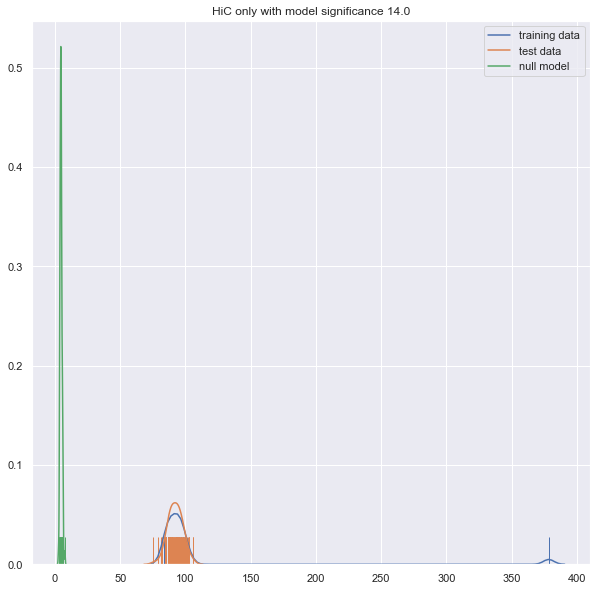

In [23]:
sns.set(rc={'figure.figsize':(10,10)})
labels = ['training data','test data', 'null model']
histos = [h1,h2,h3]
with open('with-gpseq-histos.pkl', 'wb') as f:
    pkl.dump(histos, f)

fig, ax = plt.subplots()
for count in range(3):
#     sns.distplot(histos[count], kde=False,norm_hist=True,label=labels[count],hist_kws=dict(alpha=0.7))
    sns.distplot(histos[count], rug=True, hist=False,label=labels[count])
    

# ref = Qmat(S,config_sample[ind],path)
# ax.axvline(ref,color='red',label='z-score: '+str(np.round((ref-mu)/sigma))) # draw a red vertical line at the value of S for the example graph
plt.legend()
plt.title('HiC only with model significance '+str(np.round((mu_test-mu_null)/(sigma_test+sigma_null))))
# print('z-score is: '+str((ref-mu)/sigma))  # z-score for a random S as the null model

In [29]:
import plotly
import plotly.graph_objects as go

for i in range(comm)[:20]:
    a = factors[1][1][:,i]
    b = factors[1][2][:,i]
    c = factors[1][0][:,i]
    mat = np.log1p(np.outer(S[:,i],S[:,i])) # symmetrize wrt a & b
    print(tl.norm(a,2)*tl.norm(b,2)*tl.norm(c,2))
    plt.figure(figsize=(10, 10))
#     sns.heatmap(mat,cmap='viridis',square=True,xticklabels=False,yticklabels=False)
#     plt.show()  
    fig = go.Figure(data=go.Heatmap(
                       z=mat,)
                   )
    fig.update_layout(
        title='Community '+str(i),
        showlegend = False,
        width = 1000, height = 1000,
        xaxis_title="bead#1 location on genome",
        yaxis_title="bead#2 location on genome",
    )
    axis_template = dict(range = [1,24], autorange = False,
                 showgrid = False, zeroline = False,
                 linecolor = 'black', showticklabels = True,
                 ticks = '' )
    plotly.offline.plot(fig, filename='10000G_interchrom_community-'+str(comm)+'.html')

4.573471265004866
4.510342512031569
4.197371969379927
3.859237800918409
4.877008047120254


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
ind = 3
dirname = os.fsdecode(config_sample[ind])
filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz')
A = scipy.sparse.load_npz(filename).todense()
sns.heatmap(A,cmap='Blues',square=True,xticklabels=False,yticklabels=False)

In [ ]:
for i in range(comm):
    mat = np.outer(S[:,i],S[:,i]) # symmetrize wrt a & b
    plt.figure(figsize=(10, 10))
    sns.heatmap(np.round(mat.shape[0]*mat.shape[1]*np.multiply(mat,A),decimals=3),square=True,xticklabels=False,yticklabels=False)
    plt.show()  